In [108]:
from scipy.signal import butter, lfilter
import fastdyn_fic_dmf as dmf
import numpy as np
import matplotlib.pyplot as plt
# Fetch default parameters
import tracemalloc
from scipy.io import loadmat
from scipy.stats import zscore, pearsonr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mat73
# Helper functions
def compute_fcd(data, wsize, overlap, isubdiag):
    T, N = data.shape
    win_start = np.arange(0, T - wsize - 1, wsize - overlap)
    nwins = len(win_start)
    fcd = np.zeros((len(isubdiag[0]), nwins))
    #print(fcd.shape)
    #print(data.shape)
    #print((data[win_start[2]:win_start[2] + wsize + 1, :]).shape)
    for i in range(nwins):
        tmp = data[win_start[i]:win_start[i] + wsize + 1, :]
        cormat = np.corrcoef(tmp.T)
        fcd[:, i] = cormat[isubdiag[0],isubdiag[1]]
    return fcd


C = loadmat('./data/DTI_fiber_consensus_HCP.mat')['connectivity'][:200, :200]
C = 0.2*C/np.max(C)
N = C.shape[0]



In [109]:

def sim_run(G_VAL, LR, SEED, NB_STEPS=50000):
    """
    INPUTS:
    G_VAL: float, global coupling
    LR: array, learning rate (Homogeneous or heterogenos. Decay will be calcualted for each region with this)
    SEED: int, random seed
    OUTPUTS:
    rates_dyn: np.array, dynamic of rates
    rates_inh_dyn: np.array, dynamic of inhibitory rates
    bold_dyn: np.array, dynamic of BOLD signal
    fic_t_dyn: np.array, dynamic of FIC

    """
    
    params = dmf.default_params(C=C)
    fit_res = np.load("./data/fit_res_3-44.npy")
    b = fit_res[0] # First element is the slope
    a = fit_res[1]
    params['G'] = G_VAL
    params['seed'] = SEED
    params['obj_rate'] = 3.44
    DECAY = np.exp(a+np.log(LR)*b)    
    params['lr_vector'] = LR
    params['taoj_vector'] =  DECAY
    params['J'] = 0.75*params['G']*params['C'].sum(axis=0).squeeze() + 1
    params["with_decay"] = True
    params["with_plasticity"] = True
    params['return_bold'] = False
    params["return_fic"] = True
    params["return_rate"] = True
    rates_dyn, rates_inh_dyn, _, fic_t_dyn = dmf.run(params, NB_STEPS)
    return rates_dyn, rates_inh_dyn, fic_t_dyn


import numpy as np

def vectorize_along_axis(axis=0):
    def decorator(func):
        def wrapper(data, *args, **kwargs):
            # if the data is 1D, just call the function directly
            if data.ndim == 1:
                return func(data, *args, **kwargs)
            # otherwise, apply the function along the specified axis
            return np.apply_along_axis(func, axis, data, *args, **kwargs)
        return wrapper
    return decorator

@vectorize_along_axis(axis=0)
def get_autcorr(rates):
    """Get the autocorrelation function from a 1D rates vector."""
    signal = rates - np.mean(rates)
    # Calculate autocorrelation function (full convolution)
    autocorr = np.correlate(signal, signal, mode='full')
    # Normalize: divide by the variance and length of the signal
    autocorr = autocorr / (np.var(signal) * len(signal))
    # Only keep the second half (non-negative lags)
    autocorr = autocorr[len(signal)-1:]
    return autocorr




In [114]:
# Select the nodes with the hihgest node strength from SC matrix C
node_strength = np.mean(C,axis=0)
# Get the 10 lowest regions
most_connected = np.argsort(node_strength)[::-1]


In [ ]:
G_VAL = 3.5
LR_HOMO = 1000
LR_HET = 100
LR_HOMO_VEC = np.ones(200)*LR_HOMO
SEED = 1
MAX_LAGS = 500
BURNOUT = 5000
AUTOCORR_TMAX = 5000
NB_STEPS = 10000
quimeric_delta = []
for sub_sel in range(0,N,20):
    
    rates, rates_inh, fic_t = sim_run(G_VAL, LR_HOMO_VEC, SEED)
    rates = rates[:,BURNOUT:]
    rates_inh = rates_inh[:,BURNOUT:]
    fic_t = fic_t[:,BURNOUT:]

    IDX_SEL = np.arange(0,sub_sel)
    SELECTED_HET = most_connected[IDX_SEL]
    NON_SELECTED = np.setdiff1d(np.arange(0,N),SELECTED_HET)
    LR_HET_VEC = LR_HOMO_VEC
    LR_HET_VEC[SELECTED_HET] = LR_HET

    rates_heter, rates_inh_heter, fic_t_heter = sim_run(G_VAL, LR_HET_VEC, SEED)
    rates_heter = rates_heter[:,BURNOUT:]
    rates_inh_heter = rates_inh_heter[:,BURNOUT:]
    fic_t_heter = fic_t_heter[:,BURNOUT:]


    result_heter_sel_reg = get_autcorr(np.mean(rates_heter[SELECTED_HET],axis=0))
    result_heter_non_sel_reg = get_autcorr(np.mean(rates_heter[NON_SELECTED],axis=0))
    result_sel_reg = get_autcorr(np.mean(rates[SELECTED_HET],axis=0))
    result_non_sel_reg = get_autcorr(np.mean(rates[NON_SELECTED],axis=0))
    mae=np.mean(np.abs(result_sel_reg[:AUTOCORR_TMAX]-result_non_sel_reg[:AUTOCORR_TMAX]))
    mae_heter=np.mean(np.abs(result_heter_sel_reg[:AUTOCORR_TMAX]-result_heter_non_sel_reg[:AUTOCORR_TMAX]))
    quimeric_delta.append([mae_heter/mae])



(200,)
(200,)


/home/ivan.mindlin/miniforge3/envs/fic_h/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ivan.mindlin/miniforge3/envs/fic_h/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)


In [117]:
quimeric_delta = np.array(quimeric_delta)

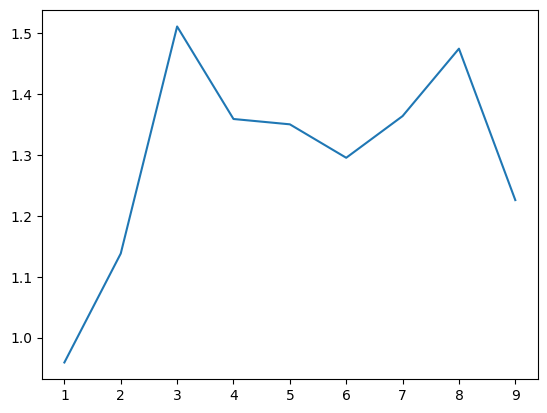

In [118]:
plt.plot(quimeric_delta)

[4.372949055113162]

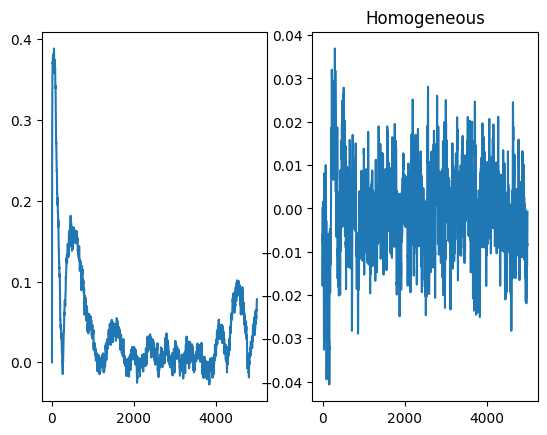

In [102]:
fig, axs = plt.subplots(nrows=1,ncols=2)
axs[0].plot(lags[:5000],np.abs(result_heter_sel_reg[:5000])-np.abs(result_heter_non_sel_reg[:5000]))
plt.title("Heterogeneous")
axs[1].plot(lags[:5000],np.abs(result_sel_reg[:5000])-np.abs(result_non_sel_reg[:5000]))
plt.title("Homogeneous")
plt.show()

In [88]:
result_heter.shape

(200, 50000)